Należy wykorzystac zbiór danych dotyczący win (Zad 2) do przetestowania algorytmu kosztu-złożoności. W szczególności należy:

1. wczytać dane,
2. nazwać kolumny (korzystając z opisu),
3. stworzyć pełne drzewo (liście z elementami jednej klasy),
4. narysować pełne drzewo,
5. sprawdzić skuteczność pełnego drzewa przez powtórne podstawienie oraz kroswalidację,
6. wybrać drzewo optymalne (za pomocą alg. kosztu-złożoności), narysować je i porównac wyniki jego skuteczności z pełnym drzewem,
7. stworzyć drzewo dla pierwszych: dwóch, trzech, czterech, itd. zmiennych - za każdym razem wyznaczyć drzewo optymalne,
8. wykreślić skuteczność drzewa w funkcji liczby użytych zmiennych, a także różnice rozmiaru drzewa pełnego i optymalnego.

In [1]:
from typing import Sequence

import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics, tree
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score

In [2]:
column_names = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols',
    'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity',
    'Hue', 'OD280/OD315 of diluted wines', 'Proline']

wines = pd.read_csv('wine.data', header=None, names=['klasa'] + column_names)

In [3]:
wines.head(10)

,klasa,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
5,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
6,1,14.39,1.87,2.45,14.6,96,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290
7,1,14.06,2.15,2.61,17.6,121,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295
8,1,14.83,1.64,2.17,14.0,97,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045
9,1,13.86,1.35,2.27,16.0,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045


`Dla pełnego drzewa`

In [4]:
#pełne drzewo
x_wines = wines.drop("klasa", axis=1)
y_wines = wines.klasa
class_names = [str(x) for x in y_wines.unique()]
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_wines, y_wines)

In [5]:
def tree_plot(
    clf: tree.DecisionTreeClassifier,
    feature_names: Sequence[str],
    class_names: Sequence[str] = class_names,
):
    plt.figure(figsize=(12, 8), dpi=300)
    tree.plot_tree(
        clf,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
    )
    plt.show()

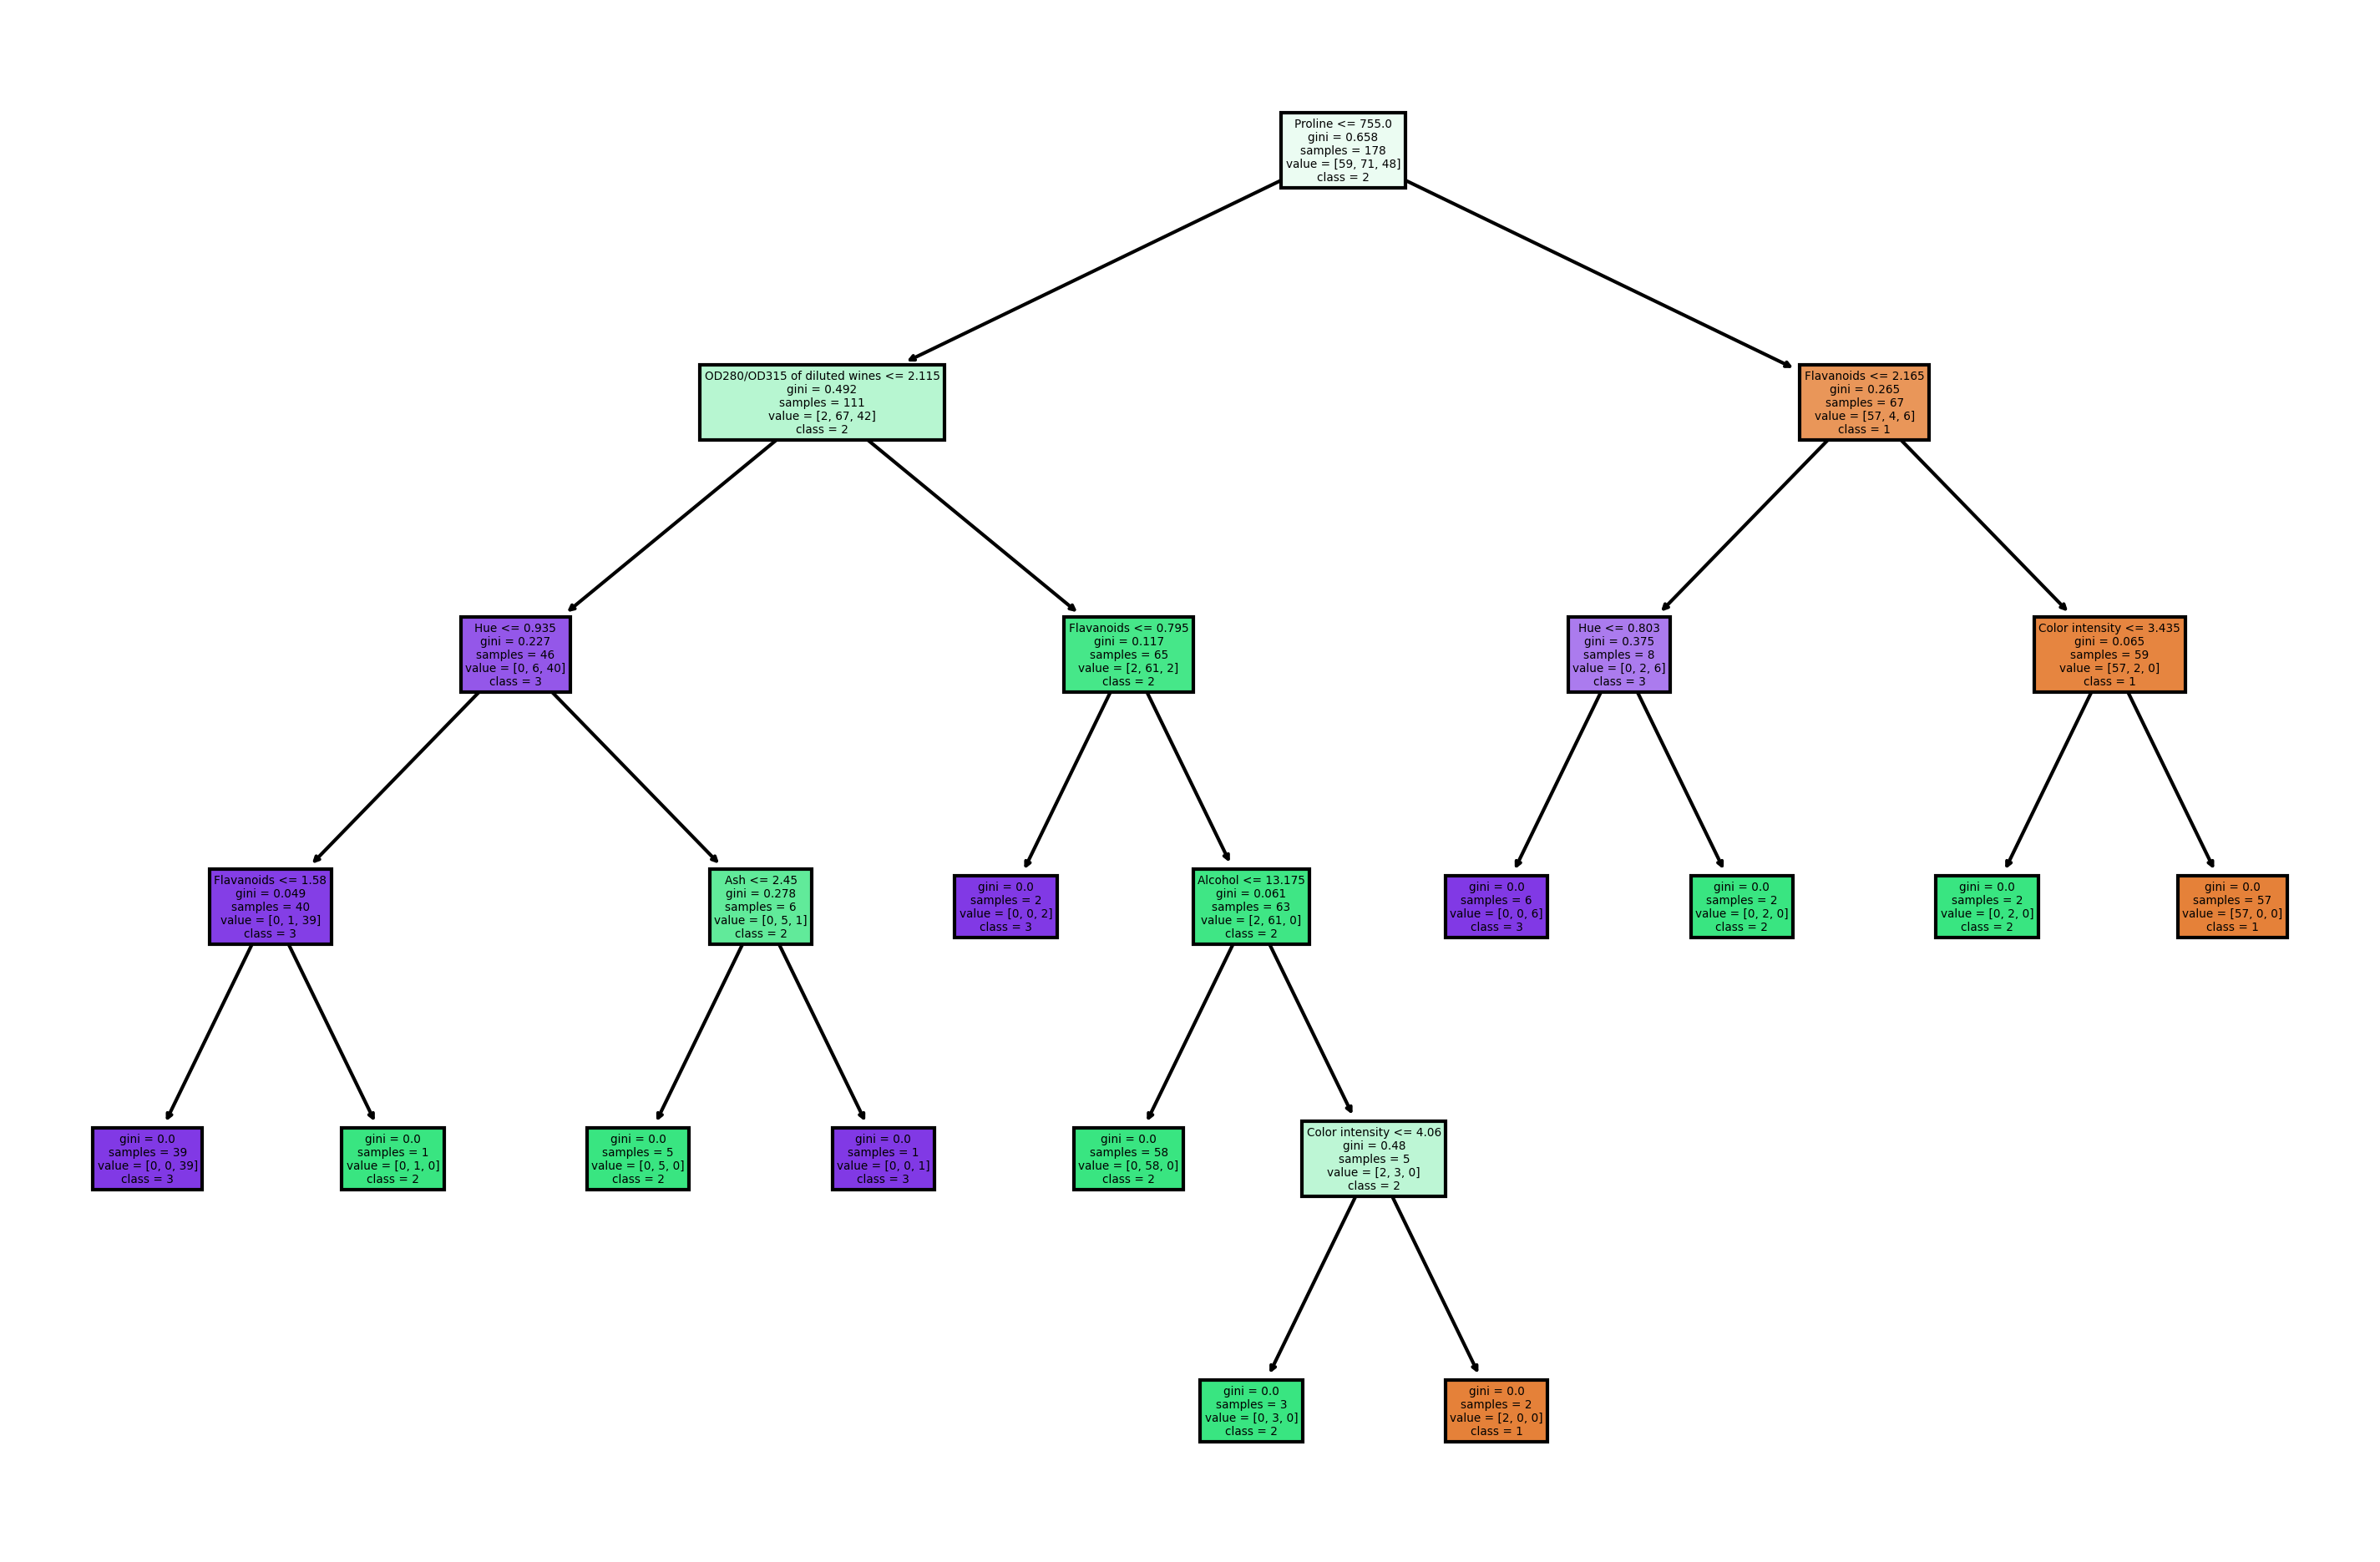

In [6]:
tree_plot(clf, list(x_wines))

In [7]:
#ponowne podstawienie
preds = clf.predict(x_wines)
print(metrics.classification_report(y_wines, preds))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        59
           2       1.00      1.00      1.00        71
           3       1.00      1.00      1.00        48

    accuracy                           1.00       178
   macro avg       1.00      1.00      1.00       178
weighted avg       1.00      1.00      1.00       178



In [8]:
#kroswalidacja
kf = RepeatedKFold(n_repeats = 5, n_splits = 5)
cross_val_score(clf, x_wines, y_wines, cv = kf).mean()


0.9033968253968254

Oczywiście dla pełnego drzewa ponowne podstawienie daje stuprocentową precyzję, natomiast dla kroswalidacji mamy tez wysoki wynik, średnio 90% skuteczności.

`Dla optymalnego drzewa`

In [9]:
def train_optimal_tree(x_values):
    clf = tree.DecisionTreeClassifier()
    path = clf.cost_complexity_pruning_path(x_values, y_wines)
    param_grid = {'ccp_alpha': path['ccp_alphas']}
    clf_grid = GridSearchCV(clf, param_grid)
    clf_grid.fit(x_values, y_wines)
    return clf_grid
clf_grid = train_optimal_tree(x_wines)


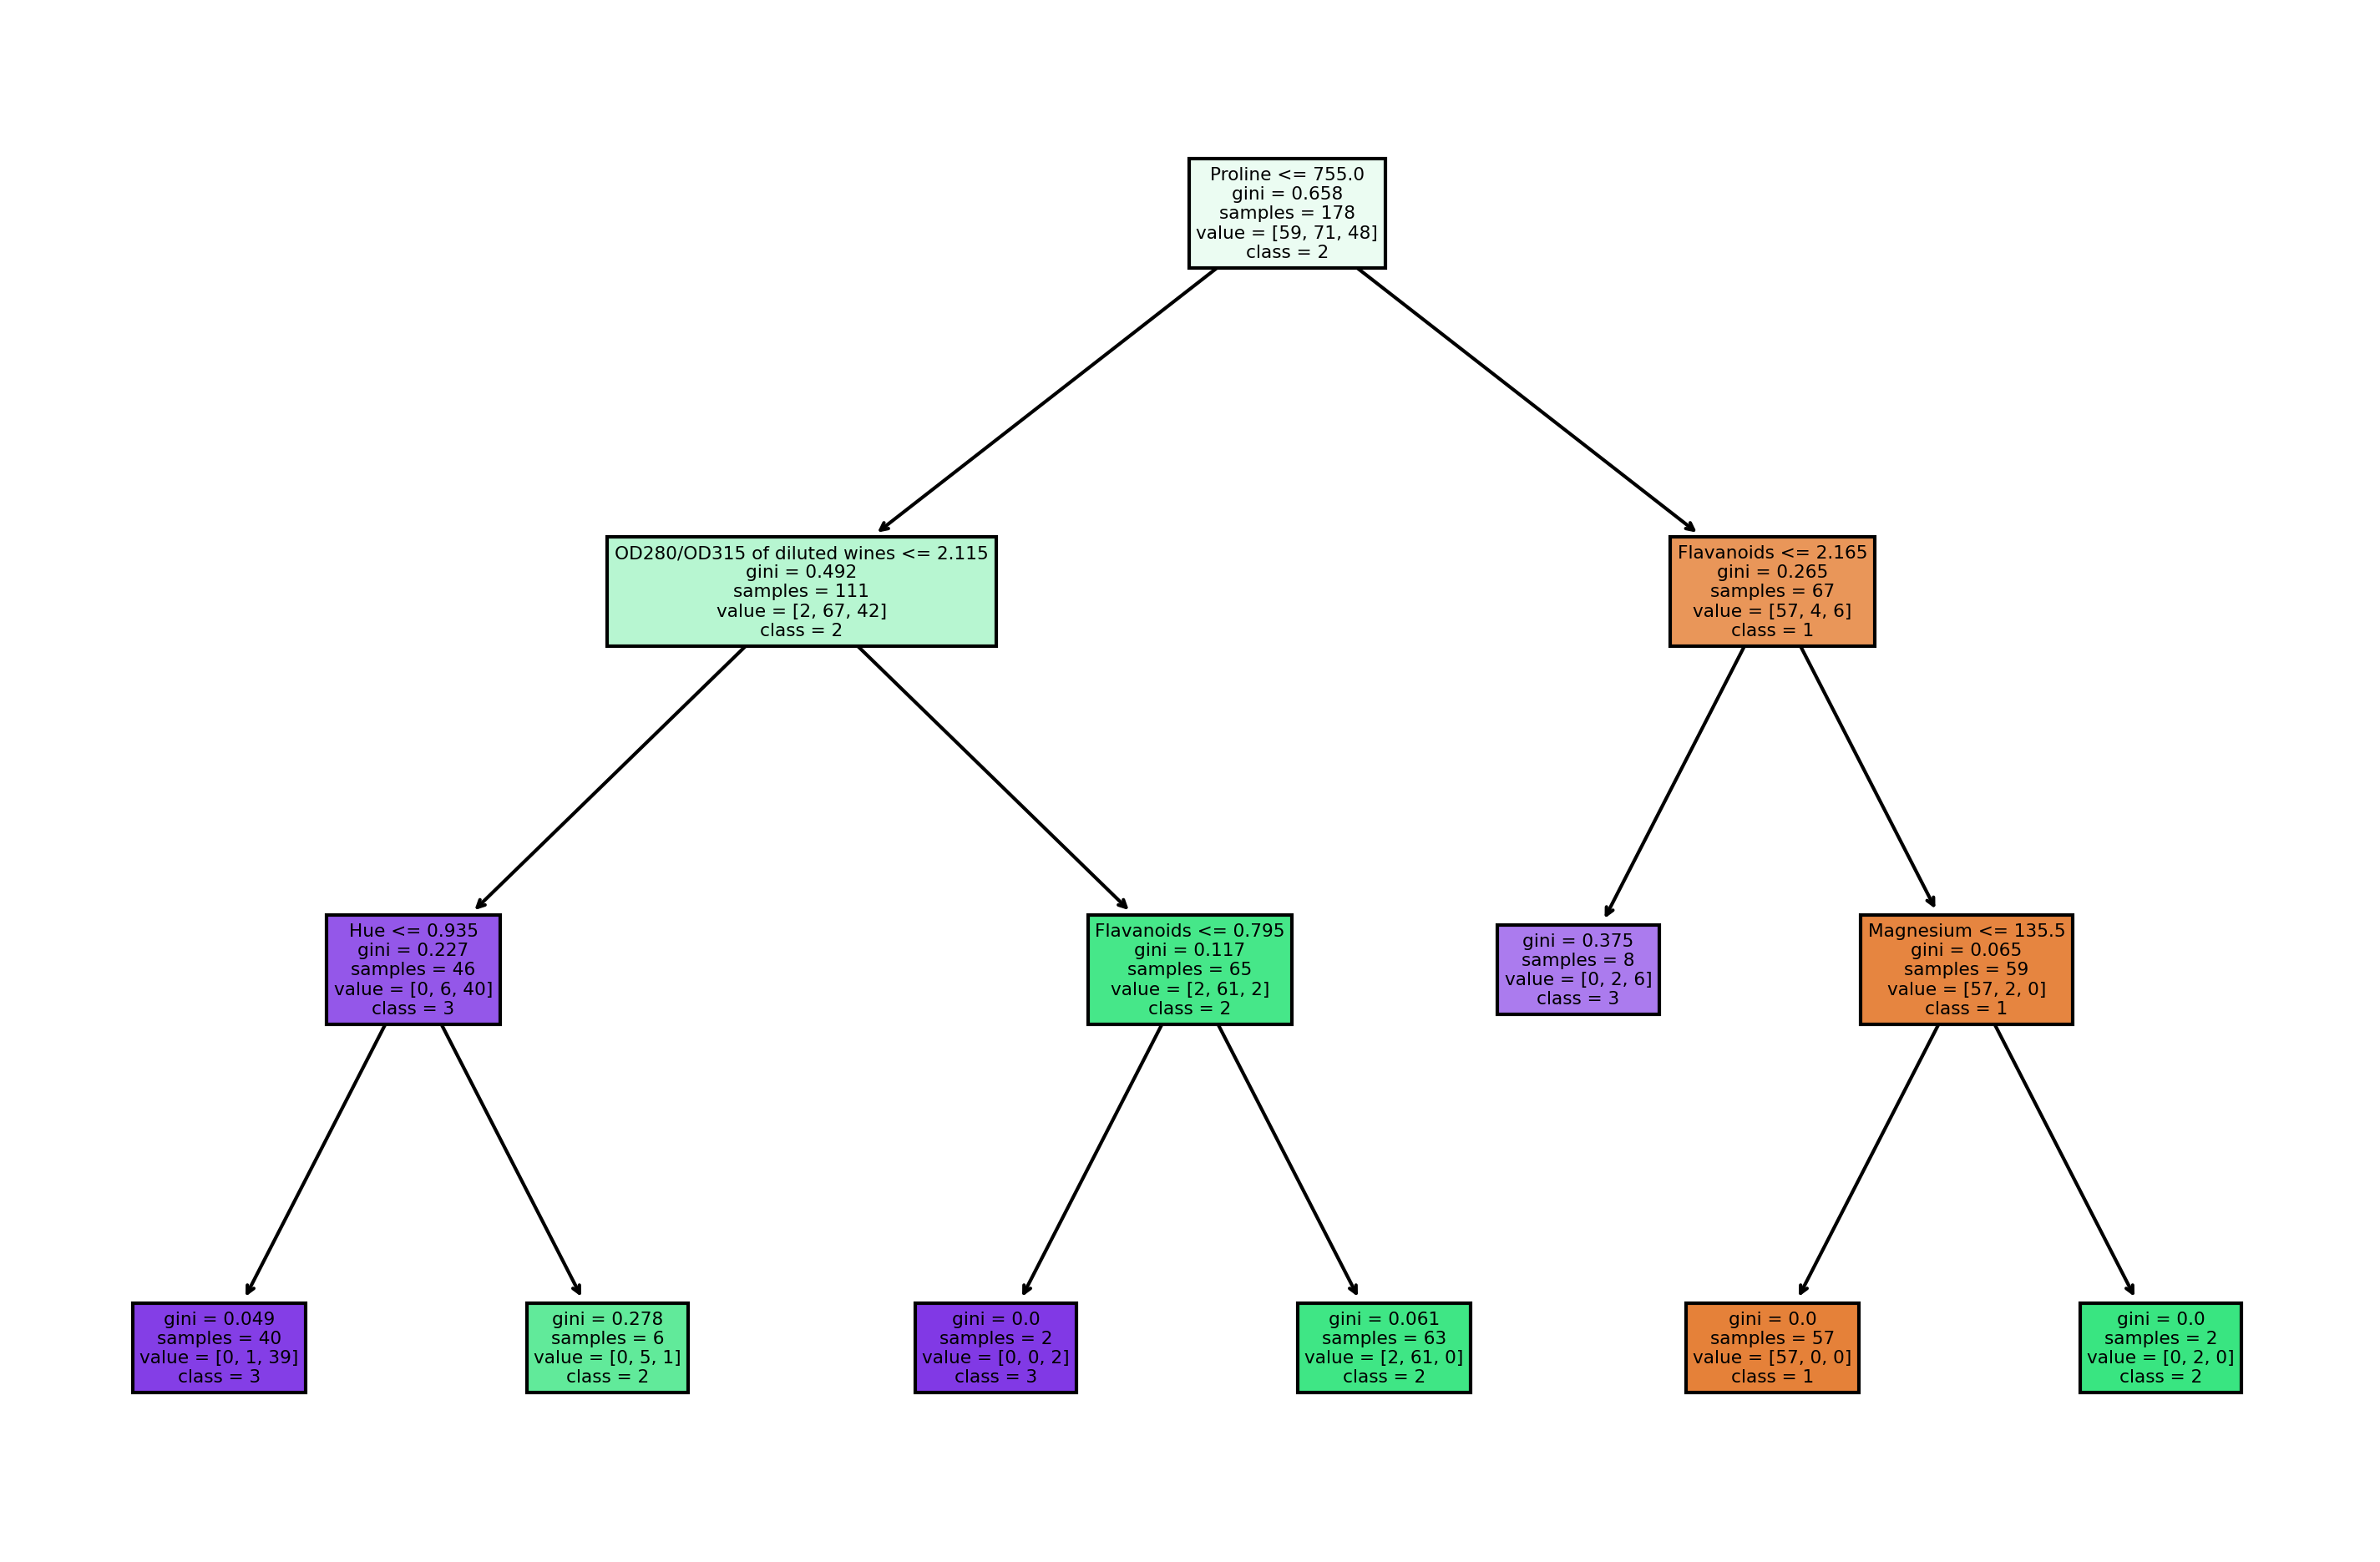

In [10]:
tree_plot(clf_grid.best_estimator_, list(x_wines))

In [11]:
#ponowne podstawienie
preds = clf_grid.best_estimator_.predict(x_wines)
print(metrics.classification_report(y_wines, preds))

              precision    recall  f1-score   support

           1       1.00      0.97      0.98        59
           2       0.96      0.96      0.96        71
           3       0.94      0.98      0.96        48

    accuracy                           0.97       178
   macro avg       0.97      0.97      0.97       178
weighted avg       0.97      0.97      0.97       178



In [12]:
cross_val_score(clf_grid.best_estimator_, x_wines, y_wines, cv = kf).mean()

0.8967301587301587

W przypadku drzewa optymalnego wydajność jest nieznacznie mniejsza, niz w przypadku drzewa pełnego. Zalezność tę obserwujemy zarówno w przypadku ponownego podstawienia jak i kroswalidacji. Oczywiście w obu przypadkach drzewa testujemy na zbiorze danych uczących, bez wydzielonego zestawu walidacyjnego.

In [13]:
num_params = []
scores = []
size_diff = []
for i in range(2, len(x_wines.columns)):
    x_df = x_wines.iloc[:,:i]
    grid = train_optimal_tree(x_df)
    score = cross_val_score(grid.best_estimator_, x_df, y_wines, cv = kf).mean()
    scores.append(score) 
    #score of the best estimator
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(x_df, y_wines)
    #difference between the number of leaves in the full tree vs optimal tree
    size_difference = clf.get_n_leaves() - grid.best_estimator_.get_n_leaves() 
    size_diff.append(size_difference)
    num_params.append(i)
    

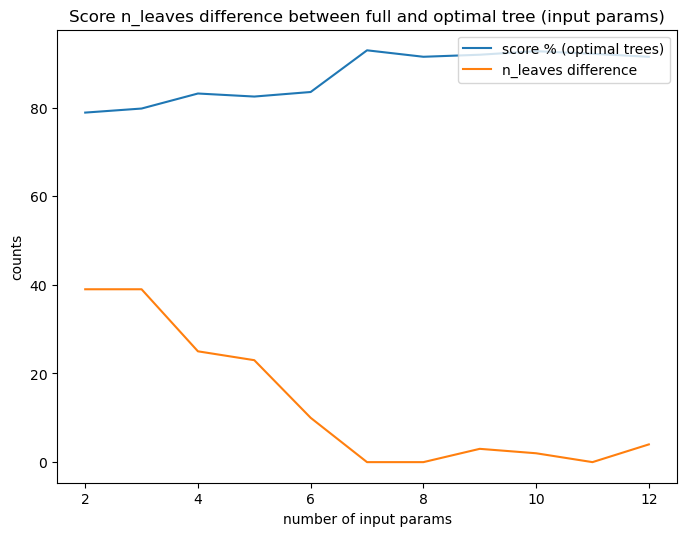

In [14]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(num_params, [s*100 for s in scores], label="score % (optimal trees)")
plt.plot(num_params, size_diff, label="n_leaves difference")
plt.xlabel("number of input params")
plt.ylabel("counts")
plt.legend(loc="upper right")
plt.title("Score n_leaves difference between full and optimal tree (input params)")
plt.show()

Wraz ze wzrostem liczby parametrów oserwujemy wzrost skuteczności optymalnych klasyfikatorów. Róznica w liczbie liści dla pełnego drzewa i optymalnego generalnie maleje wraz ze wzrostem liczby parametrów.